# ALLAN SANTOS

# **Space X  Falcon 9 First Stage Landing Prediction**

In [ ]:
%load_ext sql

#Imports
import requests
import pandas as pd
import numpy as np
import datetime
import re
import unicodedata
import sys
import csv, sqlite3
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from bs4 import BeautifulSoup
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
from math import sin, cos, sqrt, atan2, radians

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Set to see all columns and data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

prettytable.DEFAULT = 'DEFAULT'
con = sqlite3.connect('my_data1.db')
cur = con.cursor()

%sql sqlite:///my_data1.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
#Take the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
  for x in data['rocket']:
    if x:
      response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
      BoosterVersion.append(response['name'])

In [ ]:
#Take the dataset and uses the launchpad column to call the API and append the data to the list
def getLauchSite(data):
  for x in data['launchpad']:
    if x:
      response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
      Longitude.append(response['longitude'])
      Latitude.append(response['latitude'])
      LaunchSite.append(response['name'])

In [ ]:
#Take the dataset and uses the payloads column to call the API and append the data to the list
def getPayloadData(data):
  for load in data['payloads']:
    if load:
      response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
      PayloadMass.append(response['mass_kg'])
      Orbit.append(response['orbit'])

In [ ]:
#Take the dataset and uses the cores column to call the API and append the data to the list
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [ ]:
spacex_url = 'https://api.spacexdata.com/v4/launches/past'
response = requests.get(spacex_url)

In [ ]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

In [ ]:
static_json_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response = requests.get(static_json_url)
response.status_code

200

In [ ]:
data = pd.json_normalize(response.json())
print(data.head(5))

       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                                                                                                                                                                details  \
0                                                                                                                  

In [ ]:
#using the API gain to get information about the launches
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

data['date'] = pd.to_datetime(data['date_utc']).dt.date

data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [ ]:
#Set Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [ ]:
getBoosterVersion(data)

In [ ]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [ ]:
getLauchSite(data)

In [ ]:
getPayloadData(data)

In [ ]:
getCoreData(data)

In [ ]:
#Construct the dataset
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [ ]:
#Transform the launch_dict in a dataframe
launch_df = pd.DataFrame(launch_dict)
launch_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [ ]:
#Apply a filter to take out Falcon 1 data
data_falcon9 = launch_df[launch_df['BoosterVersion']!='Falcon 1']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [ ]:
#Reset the Flight number column
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [ ]:
data_falcon9.isnull().sum()

,0
FlightNumber,0
Date,0
BoosterVersion,0
PayloadMass,5
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0


In [ ]:
#Dealing with Pay load mass missing values
PayloadMass_mean = data_falcon9['PayloadMass'].mean()
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, PayloadMass_mean) # can also use data_falcon9.loc[:, 'PayloadMass'] = data_falcon9['PayloadMass'].fillna(PayloadMass_mean)

/tmp/ipython-input-22-2665287986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, PayloadMass_mean) # can also use data_falcon9.loc[:, 'PayloadMass'] = data_falcon9['PayloadMass'].fillna(PayloadMass_mean)


In [ ]:
#Return the data and time
def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

#Return the booster version
def booster_version(table_cells):
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

#Return the landing status
def landing_status(table_cells):
    out=[i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass

#Return the landing status
def extract_column_from_header(row):

    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


In [ ]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [ ]:
#request to fetch the page content
response_wiki = requests.get(static_url)

In [ ]:
#Create a beautifulsoup object from response_wiki
soup = BeautifulSoup(response_wiki.text, 'html.parser')

In [ ]:
#checking if its working
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [ ]:
#finding the target table
html_tables = soup.find_all('table')
first_launch_table = html_tables[2]

In [ ]:
#extracting column headers
column_names = []

for row in first_launch_table.find_all('th'):
    name = extract_column_from_header(row)
    if name is not None and len(name) > 0:
        column_names.append(name)

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [ ]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [ ]:
extracted_row = 0
# Extract each table
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    # get table row
    for rows in table.find_all("tr"):
        # check to see if first table heading is a number corresponding to a launch
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
            else:
                flag = False
        # get table element
        row = rows.find_all('td')
        # if it is number save cells in a dictonary
        if flag:
            # ADD THIS CHECK: Ensure the row has enough columns before proceeding
            if len(row) > 8:
                extracted_row += 1
                # Flight Number value
                launch_dict['Flight No.'].append(flight_number)
                print(f"Flight No.: {flight_number}")

                datatimelist = date_time(row[0])

                # Date value
                date = datatimelist[0].strip(',')
                launch_dict['Date'].append(date)
                print(f"Date: {date}")

                # Time value
                time = datatimelist[1]
                launch_dict['Time'].append(time)
                print(f"Time: {time}")

                # Booster version
                bv = booster_version(row[1])
                if not(bv):
                    bv = row[1].a.string
                launch_dict['Version Booster'].append(bv)

                # Launch Site
                launch_site = row[2].a.string if row[2].a else None
                launch_dict['Launch site'].append(launch_site)
                print(f"Launch_site: {launch_site}")

                # Payload
                payload = row[3].a.string if row[3].a else None
                launch_dict['Payload'].append(payload)
                print(f"Payload: {payload}")

                # Payload Mass
                payload_mass = get_mass(row[4])
                launch_dict['Payload mass'].append(payload_mass)
                print(f"Payload_mass: {payload_mass}")

                # Orbit
                orbit = row[5].a.string if row[5].a else None
                launch_dict['Orbit'].append(orbit)
                print(f"Orbit: {orbit}")

                # Customer
                customer = row[6].a.string if row[6].a else None
                launch_dict['Customer'].append(customer)
                print(f"Customer: {customer}")

                # Launch outcome
                launch_outcome = list(row[7].strings)[0]
                launch_dict['Launch outcome'].append(launch_outcome)
                print(f"Launch outcome: {launch_outcome}")

                # Booster landing
                booster_landing = landing_status(row[8])
                launch_dict['Booster landing'].append(booster_landing)
                print(f"Booster landing: {booster_landing}")

                print("-" * 40)

Flight No.: 1
Date: 4 June 2010
Time: 18:45
Launch_site: CCAFS
Payload: Dragon Spacecraft Qualification Unit
Payload_mass: 0
Orbit: LEO
Customer: SpaceX
Launch outcome: Success

Booster landing: Failure
----------------------------------------
Flight No.: 2
Date: 8 December 2010
Time: 15:43
Launch_site: CCAFS
Payload: Dragon
Payload_mass: 0
Orbit: LEO
Customer: NASA
Launch outcome: Success
Booster landing: Failure
----------------------------------------
Flight No.: 3
Date: 22 May 2012
Time: 07:44
Launch_site: CCAFS
Payload: Dragon
Payload_mass: 525 kg
Orbit: LEO
Customer: NASA
Launch outcome: Success
Booster landing: No attempt

----------------------------------------
Flight No.: 4
Date: 8 October 2012
Time: 00:35
Launch_site: CCAFS
Payload: SpaceX CRS-1
Payload_mass: 4,700 kg
Orbit: LEO
Customer: NASA
Launch outcome: Success

Booster landing: No attempt
----------------------------------------
Flight No.: 5
Date: 1 March 2013
Time: 15:10
Launch_site: CCAFS
Payload: SpaceX CRS-2
Payl

In [ ]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

In [ ]:
data_falcon9.isnull().sum()/len(df)*100

,0
FlightNumber,0.000000
Date,0.000000
BoosterVersion,0.000000
PayloadMass,0.000000
Orbit,0.000000
LaunchSite,0.000000
Outcome,0.000000
Flights,0.000000
GridFins,0.000000
Reused,0.000000


In [ ]:
data_falcon9['LaunchSite'].value_counts()

,count
LaunchSite,
CCSFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


In [ ]:
data_falcon9['Orbit'].value_counts()

,count
Orbit,
GTO,27
ISS,21
VLEO,14
PO,9
LEO,7
SSO,5
MEO,3
HEO,1
ES-L1,1


In [ ]:
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


In [ ]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [ ]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [ ]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in data_falcon9['Outcome']]

In [ ]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

/tmp/ipython-input-40-1698824859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class']=landing_class


,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [ ]:
data_falcon9.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [ ]:
data_falcon9["Class"].mean()

np.float64(0.6666666666666666)

In [ ]:
df_sql = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df_sql.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [ ]:
#DROP THE TABLE IF EXISTS

%sql DROP TABLE IF EXISTS SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


[]

In [ ]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
Done.


[]

In [ ]:
#Display the names of the unique launch sites in the space mission
%sql SELECT DISTINCT "Launch_Site" FROM SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [ ]:
%sql SELECT * FROM SPACEXTABLE WHERE "Launch_Site" LIKE "CCA%" LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [ ]:
%sql SELECT SUM("PAYLOAD_MASS__KG_") FROM SPACEXTABLE WHERE "Customer" = "NASA (CRS)";

 * sqlite:///my_data1.db
Done.


"SUM(""PAYLOAD_MASS__KG_"")"
45596


In [ ]:
%sql SELECT AVG("PAYLOAD_MASS__KG_") FROM SPACEXTABLE WHERE "Booster_Version" LIKE "F9 v1.1%";

 * sqlite:///my_data1.db
Done.


"AVG(""PAYLOAD_MASS__KG_"")"
2534.6666666666665


In [ ]:
%sql SELECT MIN(Date) FROM SPACEXTABLE WHERE "Landing_Outcome" = "Success (ground pad)";

 * sqlite:///my_data1.db
Done.


MIN(Date)
2015-12-22


In [ ]:
%sql SELECT "Booster_Version" FROM SPACEXTABLE WHERE "Landing_Outcome" = 'Success (drone ship)' AND "PAYLOAD_MASS__KG_" > 4000 AND "PAYLOAD_MASS__KG_" < 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


In [ ]:
%sql SELECT "Mission_Outcome", COUNT(*) AS 'total' FROM SPACEXTABLE GROUP BY "Mission_Outcome";

 * sqlite:///my_data1.db
Done.


Mission_Outcome,total
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [ ]:
%sql SELECT "Booster_Version" FROM SPACEXTABLE WHERE "PAYLOAD_MASS__KG_" = (SELECT MAX("PAYLOAD_MASS__KG_") FROM SPACEXTABLE);

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [ ]:
%sql SELECT SUBSTR(Date, 6, 2) as "Month", "Landing_Outcome", "Booster_Version", "Launch_Site" FROM SPACEXTABLE WHERE SUBSTR(Date, 1, 4) = '2015' AND "Landing_Outcome" = "Failure (drone ship)";

 * sqlite:///my_data1.db
Done.


Month,Landing_Outcome,Booster_Version,Launch_Site
01,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
04,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


In [ ]:
%sql SELECT "Landing_Outcome", COUNT(*) AS "Outcome_Count" FROM SPACEXTABLE WHERE Date BETWEEN "2010-06-04" AND "2017-03-20" GROUP BY "Landing_Outcome" ORDER BY "Outcome_Count" DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Outcome_Count
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


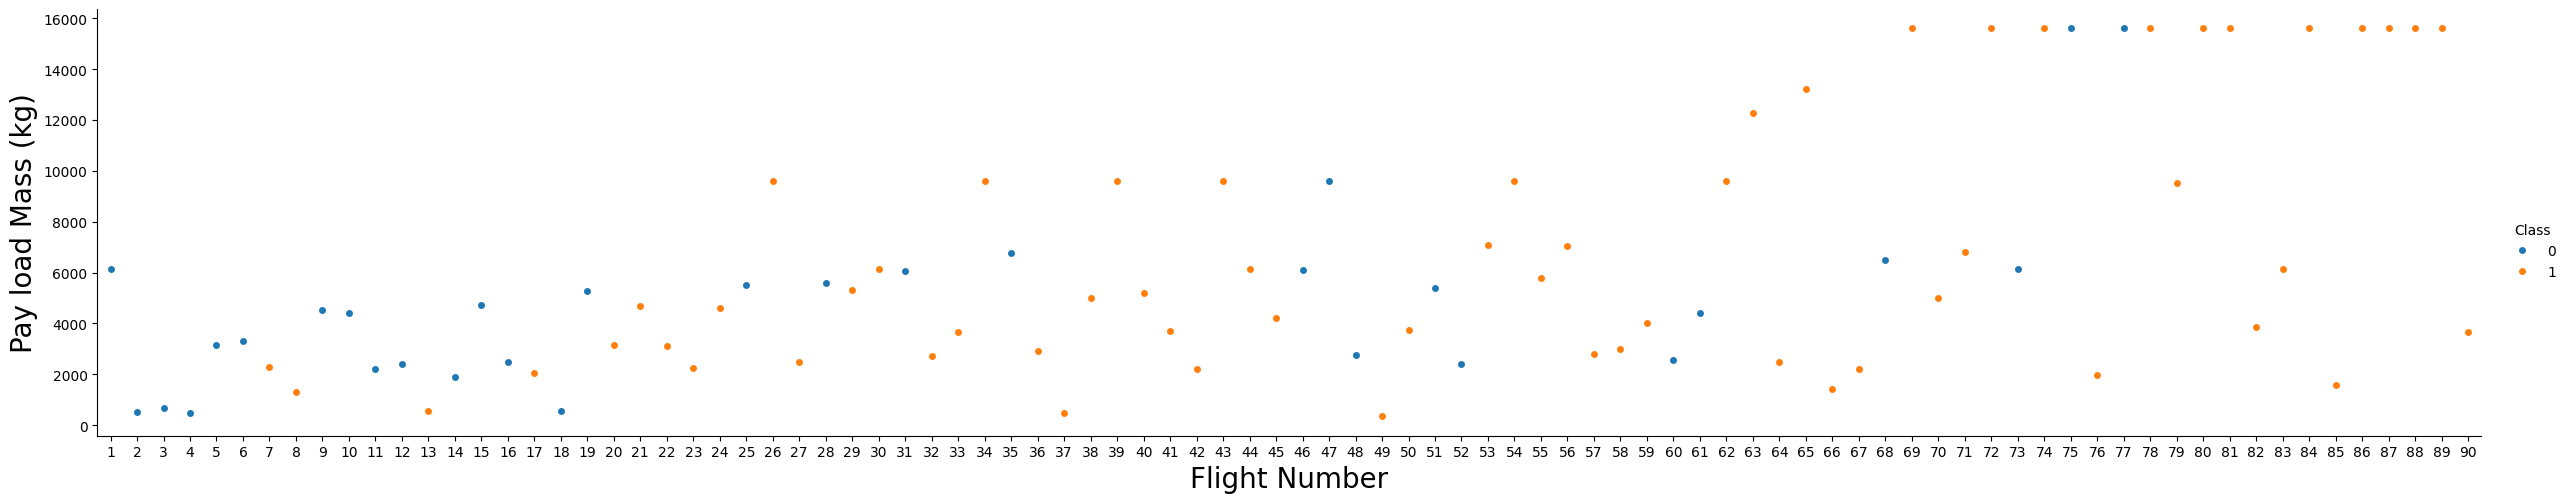

In [ ]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

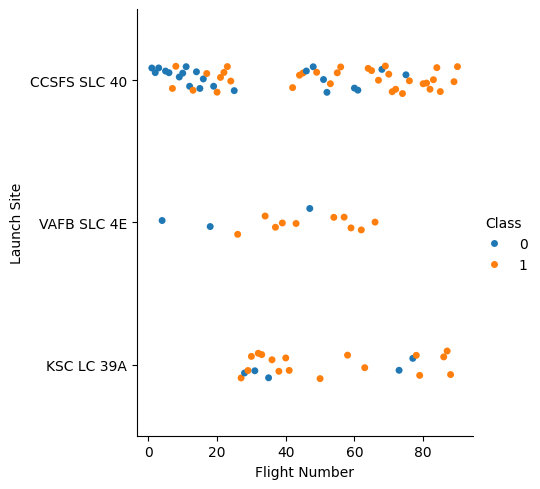

In [ ]:
sns.catplot(data=data_falcon9, x='FlightNumber', y='LaunchSite', hue='Class', aspect = 1)
plt.xlabel('Flight Number')
plt.ylabel('Launch Site')
plt.show()

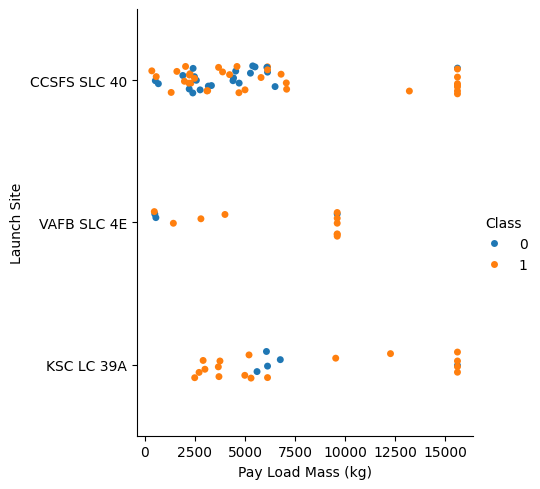

In [ ]:
sns.catplot(data=data_falcon9, x='PayloadMass', y='LaunchSite', hue='Class')
plt.xlabel('Pay Load Mass (kg)')
plt.ylabel('Launch Site')
plt.show()

<Axes: xlabel='Orbit', ylabel='Class'>

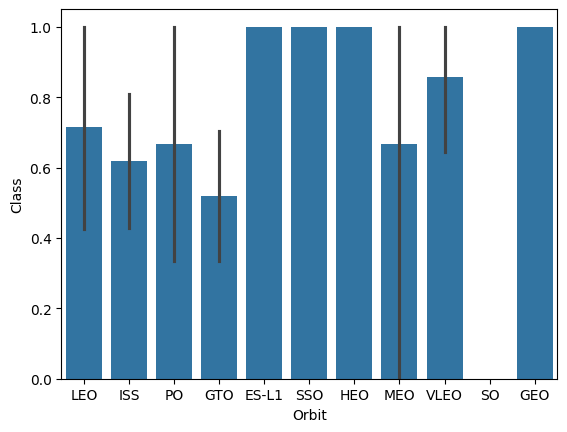

In [ ]:
sns.barplot(data=data_falcon9, x='Orbit', y='Class')

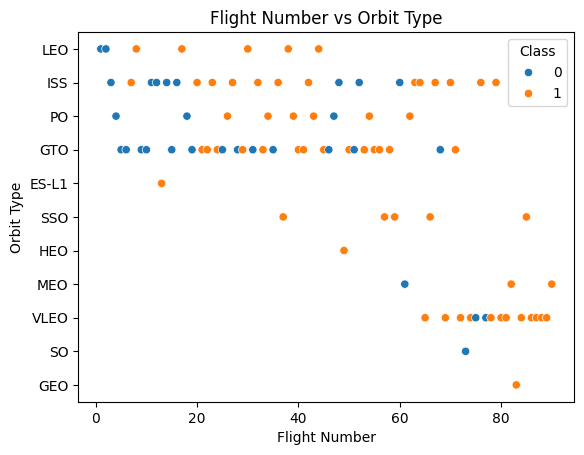

In [ ]:
sns.scatterplot(data=data_falcon9, x='FlightNumber', y='Orbit', hue='Class')
plt.title('Flight Number vs Orbit Type')
plt.xlabel('Flight Number')
plt.ylabel('Orbit Type')
plt.show()

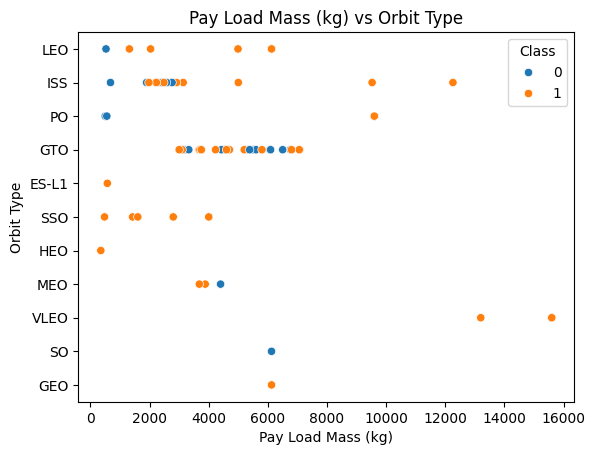

In [ ]:
sns.scatterplot(data=data_falcon9, x='PayloadMass', y='Orbit', hue='Class')
plt.title('Pay Load Mass (kg) vs Orbit Type')
plt.xlabel('Pay Load Mass (kg)')
plt.ylabel('Orbit Type')
plt.show()

In [ ]:
data_falcon9['Date'] = pd.to_datetime(data_falcon9['Date'])
data_falcon9['Year'] = data_falcon9['Date'].dt.year

data_falcon9.head()

/tmp/ipython-input-62-2508785937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Date'] = pd.to_datetime(data_falcon9['Date'])
/tmp/ipython-input-62-2508785937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Year'] = data_falcon9['Date'].dt.year


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013


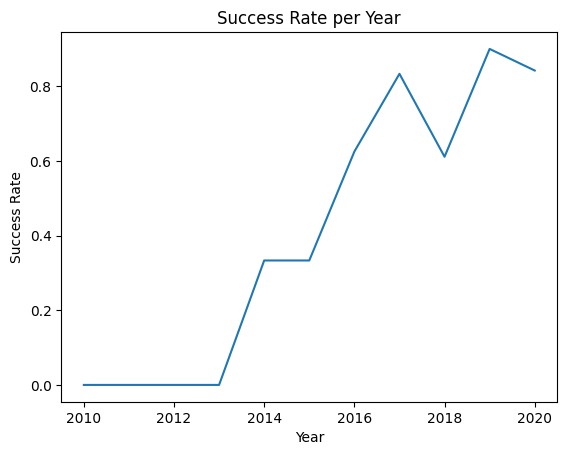

In [ ]:
df_year_success = data_falcon9.groupby('Year')['Class'].mean().reset_index()

sns.lineplot(data=df_year_success, x='Year', y='Class')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.title('Success Rate per Year')
plt.show()

In [ ]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [ ]:
features_one_hot = pd.get_dummies(features, columns=['Orbit','LaunchSite','LandingPad','Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,2,525.000000,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,3,677.000000,1,False,False,False,1.0,0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,4,500.000000,1,False,False,False,1.0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,5,3170.000000,1,False,False,False,1.0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
features_one_hot = features_one_hot.astype(float)

features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
features_one_hot.shape

(90, 80)

In [ ]:
# Isso evita criar marcadores duplicados para o mesmo local
launch_sites_df = data_falcon9[['LaunchSite', 'Latitude', 'Longitude']].drop_duplicates()

# Centralizando o mapa na média das coordenadas dos locais
start_lat = launch_sites_df['Latitude'].mean()
start_lon = launch_sites_df['Longitude'].mean()
site_map = folium.Map(location=[start_lat, start_lon], zoom_start=4)

# Criar um objeto MarkerCluster e adicioná-lo ao mapa
marker_cluster = MarkerCluster().add_to(site_map)

# Iterar sobre cada local e adicionar um marcador ao MarkerCluster
for index, row in launch_sites_df.iterrows():
    site_name = row['LaunchSite']
    lat = row['Latitude']
    lon = row['Longitude']

    marker = folium.Marker(
        location=[lat, lon],
        popup=site_name,
        icon=folium.Icon(color='blue', icon='rocket') # Ícone customizado
    )

    # Adicionar o marcador ao cluster
    marker.add_to(marker_cluster)

# Adicionar o plugin para mostrar a posição do mouse
MousePosition().add_to(site_map)

site_map

In [ ]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [ ]:
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [ ]:
site_map = folium.Map(location=[29.559684888503615, -95.0830971930759], zoom_start=5)
marker_cluster = MarkerCluster().add_to(site_map)

# Itere sobre cada linha do dataframe de lançamentos
for index, record in data_falcon9.iterrows():
    # Defina a cor do marcador com base na coluna 'Class'
    if record['Class'] == 1:
        icon_color = 'green'
    else:
        icon_color = 'red'

    # Crie e adicione o marcador ao cluster
    marker = folium.Marker(
        location=[record['Latitude'], record['Longitude']],
        # Crie um ícone com a cor definida
        icon=folium.Icon(color='white', icon_color=icon_color),
        popup=f"Local: {record['LaunchSite']}<br>Resultado: {'Sucesso' if record['Class'] == 1 else 'Falha'}"
    )
    marker.add_to(marker_cluster)

site_map

In [ ]:
marker_cluster = MarkerCluster()

data_falcon9['marker_color'] = data_falcon9['Class'].apply(lambda x: 'green' if x == 1 else 'red')

site_map.add_child(marker_cluster)

for index, record in data_falcon9.iterrows():
    # Cria e adiciona o Marcador ao cluster
    marker = folium.Marker(
        location=[record['Latitude'], record['Longitude']],
        icon=folium.Icon(color='white', icon_color=record['marker_color']),
        popup=f"Local: {record['LaunchSite']}<br>Resultado: {'Sucesso' if record['Class'] == 1 else 'Falha'}"
    )
    marker_cluster.add_child(marker)

# Exibe o mapa
site_map

/tmp/ipython-input-72-1745756035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['marker_color'] = data_falcon9['Class'].apply(lambda x: 'green' if x == 1 else 'red')


In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [ ]:
launch_site_df = data_falcon9[data_falcon9['LaunchSite'] == 'CCSFS SLC 40']
launch_site_lat = launch_site_df.iloc[0]['Latitude']
launch_site_lon = launch_site_df.iloc[0]['Longitude']

coastline_lat = 28.56367
coastline_lon = -80.56794

distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
print(f"Distância até a costa: {distance_coastline:.2f} KM")

# Criar um marcador no ponto da costa para exibir a distância
distance_marker = folium.Marker(
   location=[coastline_lat, coastline_lon],
   icon=folium.DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       # Cria um ícone customizado com HTML para mostrar o valor da distância
       html=f'<div style="font-size: 12; color:#d35400;"><b>{distance_coastline:.2f} KM</b></div>',
       )
   )
site_map.add_child(distance_marker)

# Desenhar uma linha PolyLine entre o local de lançamento e a costa
lines = folium.PolyLine(
    locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]],
    weight=1
)
site_map.add_child(lines)

site_map

Distância até a costa: 0.94 KM


In [ ]:
print(data_falcon9['LaunchSite'].unique())

['CCSFS SLC 40' 'VAFB SLC 4E' 'KSC LC 39A']


In [ ]:
launch_site_df = data_falcon9[data_falcon9['LaunchSite'] == 'CCSFS SLC 40']

launch_site_lat = launch_site_df.iloc[0]['Latitude']
launch_site_lon = launch_site_df.iloc[0]['Longitude']

In [ ]:
pontos_de_interesse = {
    'Ferrovia': [28.57205, -80.58525],
    'Rodovia (Samuel C Phillips Pkwy)': [28.56327, -80.57076],
    'Cidade (Cape Canaveral)': [28.4013, -80.6041]
}

In [ ]:
for nome, coords in pontos_de_interesse.items():
    lat, lon = coords
    distancia = calculate_distance(launch_site_lat, launch_site_lon, lat, lon)

    # Adiciona o marcador com a distância
    folium.Marker(
       location=coords,
       icon=folium.DivIcon(
           icon_size=(20,20),
           icon_anchor=(0,0),
           html=f'<div style="font-size: 12; color:#d35400;"><b>{distancia:.2f} KM</b></div>',
           )
       ).add_to(site_map)

    # Adiciona a linha de conexão
    folium.PolyLine(
        locations=[[launch_site_lat, launch_site_lon], coords],
        weight=1
    ).add_to(site_map)

# Exibe o mapa com todas as linhas
site_map

In [ ]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [ ]:
Y = data_falcon9['Class'].to_numpy()

In [ ]:
X = features_one_hot

In [ ]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
Y_test.shape

(18,)

# Logistic Regression

In [ ]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [ ]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

In [ ]:
lr_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)

In [ ]:
lr_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [ ]:
print("tuned hyperparameters :(best parameters) ",lr_cv.best_params_)
print("accuracy :",lr_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [ ]:
accuracy = lr_cv.score(X_test, Y_test)
accuracy

0.8333333333333334

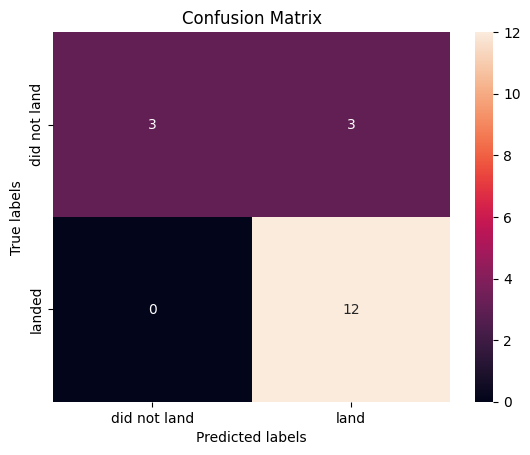

In [ ]:
yhat = lr_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

# Support Vector Machine

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [ ]:
svm_cv = GridSearchCV(estimator=svm, param_grid=parameters, cv=10)

svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [ ]:
print("tuned hyperparameters :",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hyperparameters : {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


In [ ]:
svm_cv_accuracy = svm_cv.score(X_test, Y_test)
svm_cv_accuracy

0.8333333333333334

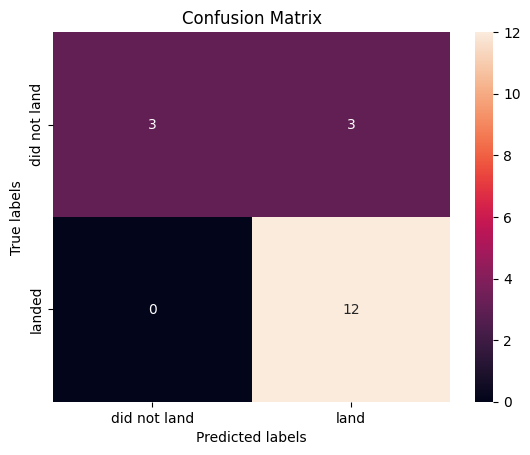

In [ ]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

# Decision Tree Classifier

In [ ]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [ ]:
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=10)

tree_cv.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8732142857142857


In [ ]:
tree_cv_accuracy = tree_cv.score(X_test, Y_test)
tree_cv_accuracy

0.8888888888888888

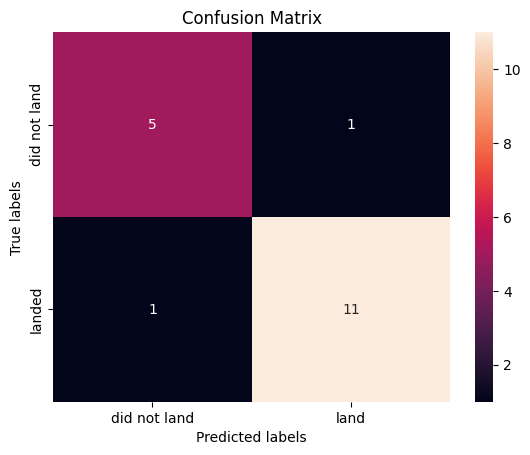

In [ ]:
yhat=tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

# k nearest neighbors

In [ ]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn = KNeighborsClassifier()

In [ ]:
knn_cv = GridSearchCV(estimator=knn, param_grid=parameters, cv=10)

knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [ ]:
knn_cv_accuracy = knn_cv.score(X_test, Y_test)
knn_cv_accuracy

0.7777777777777778

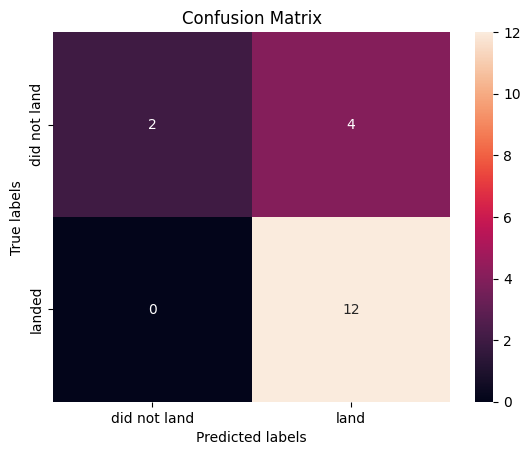

In [ ]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

# the Decision Tree Classifier - performs better